# User behavior analysis by sessions

## Background
* The company operates a travel booking website, similar to Expedia.
* The marketing team is focused on increasing the conversion rate of hotel bookings made through the site.
* The marketing team discovered that a significant proportion of the site's traffic leaves without booking a hotel. Therefore, in collaboration with the marketing team, we've developed a strategy to increase the conversion rate by identifying and specifically targeting a subgroup of website visitors who show a higher likelihood of booking hotels.

## Strategy & Methodology
* **Project goal**: Identify patterns in user behavior that indicate a high intent to book a hotel through the company website.
* **Business strategy**: 
    * The marketing team has identified two categories of users based on their intention to book hotels: those actively planning a trip and those merely casually browsing. We aim to classify users and focus our efforts on the former group, given their higher booking intent. Our strategy aims to boost the number of hotel bookings by encouraging these users to return to our website and finalize their bookings.
    * Based on previous research conducted by the marketing team, there's a link between users' search queries within a session and their likelihood of booking a hotel versus merely browsing. That is, when users are planning a near-future trip, they typically already have a destination in mind and tend to search for cities close to one another. In contrast, users casually browsing potential destinations for future trips tend to search for cities located far apart. For instance, a user searching for Los Angeles, San Diego, and Las Vegas in the same session is significantly more likely to book a hotel than a user searching for Tokyo, London, and Sydney.

* **Data Science Methodology**: 
    * Based on the business strategy, we chose the machine learning method of clustering analysis. We aim to cluster users based on their browsing behavior within a session. 
    * Clustering analysis is an unsupervised machine learning method that doesn't require a labeled response variable. In other words, we don't have a variable indicating whether a user leaves the website with a booking.
    * We chose unsupervised machine learning because the majority of website visitors leave without making a booking, resulting in an extremely low signal-to-noise ratio. It would be challenging for a supervised learning model to classify the users in a meaningful way.
    * Furthermore, people often don't complete their booking in a single session. They might browse hotels and return a few days later to make a booking. Consequently, a label indicating whether a booking was made in a given session doesn't accurately reflect a user's booking intent. By using an unsupervised learning method, we can target users based purely on their behavior, not the specific outcome of a session.

## Data

**Data**: We need to gather relevant data to understand user behavior. Here are some crucial data points we should consider: 
* User interaction data on the site (e.g., search queries, time spent)
* User profile data
* Previous booking history
* Data about the user's device and location
* Data about the when we conduct this analysis
* External data about the travel trend 
    
It's likely that the **user interaction** data will be far more informative than other types of data. User interactions, such as when and what they search for, reveal moments when users are planning something. The time component is important compared to demographic data, which tends to be more static. Based on this idea, we included the data of users' search queries within a session, along with some basic information about the user and the cities.

The data is stored and accessed through APIs from a CRM (Customer Relationship Management) system and the company's server logs. This data is stored in JSON files. Each entry in the JSON file displays various cities searched by a user within the same session, along with additional user information.


### More about the data
The file is:

city_searches - a list of searches happening within the same session

Fields:

* session_id : session id. Unique by row
* unix_timestamp : unixtime stamp of when the session started
* cities : the unique cities which were searched for within the same session by a user
* user : it has the following nested fields: 
    * user_id: the id of the user
    * joining_date: when the user created the account
    * country: where the user is based

In [2]:
import pandas as pd
import json 
import statistics 
import urllib 
import numpy as np 
import scipy 
import matplotlib.pyplot as plt 
import folium
import branca
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns 
import mpld3
import datetime
import time
import requests
from math import radians, sin, cos, sqrt, atan2
import itertools
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_theme()
sns.set(style="ticks")
pd.set_option('display.max_columns', 10) 
pd.set_option('display.width', 350)

## Data loading & preprocessing

### 1. Read data

In [3]:

data_path = '/Users/bing/Documents/Data_Science/project_data/sessionize_user/'
data_json = json.loads(open(data_path + 'city_searches.json').read())

In [4]:
len(data_json)

20022

There are 20,022 entries in this JSON file.

### 2. Extract the data from JSON file to a dataframe

In [5]:
data_json[0]

{'session_id': ['D258NVMV202LS'],
 'unix_timestamp': [1442640552],
 'cities': ['San Jose CA, Montreal QC'],
 'user': [[{'user_id': 5749, 'joining_date': '2015-04-02', 'country': 'FR'}]]}

JSON objects are essentially key-value pairs, much like dictionaries. To build a pandas dataframe with each key-value pair as a column, we have to extract the nested fields of some keys.
* We have three keys that can be used as a dataframe column directly and one key 'user' that needs to be extracted.

In [18]:
# Extract the keys from the JSON file
list(data_json[0].keys())[0:3] + list(data_json[0]['user'][0][0].keys() )


['session_id',
 'unix_timestamp',
 'cities',
 'user_id',
 'joining_date',
 'country']

In [24]:
# Define a function to extract the data from JSON file to a dataframe
def json_to_df(data_json):
    # Extract the keys from the JSON file
    columns = list(data_json[0].keys())[0:3] + list(data_json[0]['user'][0][0].keys() )
    df = pd.DataFrame(columns = columns)
    for i in range(len(data_json)):
        for j in range(len(columns)):
            if j < 3:
                df.loc[i, columns[j]] = data_json[i][columns[j]][0]
            else:
                df.loc[i, columns[j]] = data_json[i]['user'][0][0][columns[j]] 
    return df


In [25]:
data = json_to_df(data_json)

In [26]:
print("The dimensions of the data set are:", data.shape[0], "observations and", data.shape[1], "variables." )
data.head()

The dimensions of the data set are: 20022 observations and 6 variables.


,session_id,unix_timestamp,cities,user_id,joining_date,country
0,D258NVMV202LS,1442640552,"San Jose CA, Montreal QC",5749,2015-04-02,FR
1,TDG10UKG7I4LR,1432110137,New York NY,10716,2015-03-30,DE
2,OH4ZDIGN9BLQS,1437049311,"Montreal QC, Quebec QC",2941,2015-03-16,
3,CWHIAYKQ7RA28,1432215908,Chicago IL,2164,2015-03-27,FR
4,GI8GZJAWAC80P,1443556226,"Toronto ON, Houston TX",10493,2015-03-31,US


We do not split the data set into training and testing because we are conducting unsupervised modeling. Since there is no target variable, or "truth" variable, we can not verify the result with a test data set.

### 3. Check the data types, and data values

In [28]:
# Let's make that each variable is in the correct data type
data.dtypes

session_id        object
unix_timestamp    object
cities            object
user_id           object
joining_date      object
country           object
dtype: object

In [32]:
# Convert the timestamp to datetime format
data['action_date'] = pd.to_datetime(data['unix_timestamp'], unit = 's')

In [47]:
# Convert the 'joining_date' to datetime format
data['joining_date'] = pd.to_datetime(data['joining_date'], format = '%Y-%m-%d')

In [49]:
# Convert 'country' to categorical variable
data['country'] = data['country'].astype('category')

In [50]:
data.dtypes

session_id                object
unix_timestamp            object
cities                    object
user_id                   object
joining_date      datetime64[ns]
country                 category
action_date       datetime64[ns]
dtype: object

In [52]:
data.head()

,session_id,unix_timestamp,cities,user_id,joining_date,country,action_date
0,D258NVMV202LS,1442640552,"San Jose CA, Montreal QC",5749,2015-04-02,FR,2015-09-19 05:29:12
1,TDG10UKG7I4LR,1432110137,New York NY,10716,2015-03-30,DE,2015-05-20 08:22:17
2,OH4ZDIGN9BLQS,1437049311,"Montreal QC, Quebec QC",2941,2015-03-16,,2015-07-16 12:21:51
3,CWHIAYKQ7RA28,1432215908,Chicago IL,2164,2015-03-27,FR,2015-05-21 13:45:08
4,GI8GZJAWAC80P,1443556226,"Toronto ON, Houston TX",10493,2015-03-31,US,2015-09-29 19:50:26


In [ ]:
# The other variables are in the correct data type and value format. 

### 4. Check missing values and outliers

For missing values, we want to check:
1) If there are missing values in the data set
2) If there are missing levels for categorical data

For outliers, we want to check: 
1) If the range of numerical variables is reasonable
2) If the level of categorical variables makes sense
3) The redundancy of records. If an user has multiple records, we want to check if the records are the same or different.


#### Let's first take a look at the missing values


In [108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20022 entries, 0 to 20021
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   session_id      20022 non-null  object        
 1   unix_timestamp  20022 non-null  object        
 2   cities          20022 non-null  object        
 3   user_id         20022 non-null  object        
 4   joining_date    20022 non-null  datetime64[ns]
 5   country         20022 non-null  category      
 6   action_date     20022 non-null  datetime64[ns]
dtypes: category(1), datetime64[ns](2), object(4)
memory usage: 1.6+ MB


hmmm, it looks like there is no missing values for all the variables. However, for the data with Dtypes as object and category, we need to check if there is missing values marked with stings like '', ' '. These strings are non-null but are actual missing values.

In [106]:
print("missing values:")
for col in data.columns:
    print(col, ":", np.sum([data[col].isnull(), data[col] == '', data[col] == ' ']))

missing values:
session_id : 0
unix_timestamp : 0
cities : 0
user_id : 0
joining_date : 0
country : 2769
action_date : 0


Aha! We found that there are missing values in the country variable. Let's note it down and deal with the missing values when we work on the country variable.

#### Now let's check outliers for each variable

In [107]:
data.describe()

,session_id,unix_timestamp,cities,user_id,joining_date,country,action_date
count,20022,2.002200e+04,20022,20022.0,20022,20022,20022
unique,20022,2.000100e+04,1293,9252.0,35,7,20001
top,D258NVMV202LS,1.442236e+09,New York NY,10901.0,2015-03-14 00:00:00,US,2015-09-14 13:05:52
freq,1,2.000000e+00,2296,8.0,784,3772,2
first,NaN,NaN,NaN,NaN,2015-02-28 00:00:00,NaN,2015-03-01 00:23:10
last,NaN,NaN,NaN,NaN,2015-04-03 00:00:00,NaN,2015-10-02 01:00:35


* session_id
    * We can see session_id is unique for each session.
* the dates
    * unix_timestamp is converted to action_date
    * joining date: It seems that we selected the users who registered between March 14th, 2015 to April 3rd, 2015.
    * action date: It seems that the search queries we pulled are from March 1st, 2015 to October 2nd, 2015

In [67]:
# Let's check if the action date is after the joining date
if data[data['action_date'] < data['joining_date']].shape[0] > 0:
    print("There are outliers in the date.")
else:
    print("There are no outliers in the date. The action date is after the joining date.")

There are no outliers in the date. The action date is after the joining date.


* Check if the number of cities searched is reasonable
    * A user can search multiple cities in one session, but if the number of cities searched in one session is too large, it is suspicious and can be a **bot**.
    * Since the cities searched are splitted by ',' in the same string, we need to count the number of ',' in the string and plus one so we get the number of cities searched in a session.

In [64]:
cities_searched = data['cities'].apply(lambda x: x.count(',') + 1)
cities_searched.describe()

count    20022.000000
mean         1.651733
std          0.859390
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          8.000000
Name: cities, dtype: float64

Text(0.5, 1.0, 'Boxplot of the number of cities searched in one session')

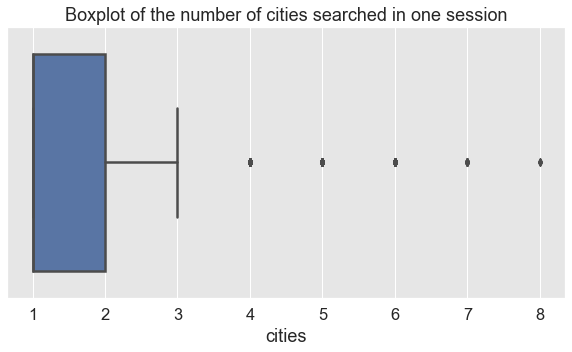

In [87]:
# Draw a boxplot to check the outliers
f, ax = plt.subplots(1,1, figsize=(10, 5))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
ax = sns.boxplot(cities_searched)
ax.set_title('Boxplot of the number of cities searched in one session')

Most of the users search between 1 to 3 cities in a session. The largest number of cities searched in a session is 8, which is still reasonable for a human user (not a bot). We keep all the records.

* Check how many sessions each user has 
    * If a user have too many sessions, then it might be a bot.

In [88]:
sessions_per_user = data.groupby('user_id')['session_id'].count().reset_index()

In [90]:
sessions_per_user['session_id'].describe()

count    9252.000000
mean        2.164073
std         1.167005
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         8.000000
Name: session_id, dtype: float64

Text(0.5, 1.0, 'Boxplot of the number of sessions per user')

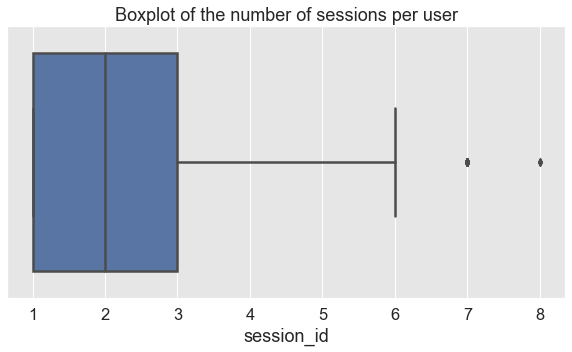

In [91]:
# draw a boxplot to check the outliers
f, ax = plt.subplots(1,1, figsize=(10, 5))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
ax = sns.boxplot(sessions_per_user['session_id'])
ax.set_title('Boxplot of the number of sessions per user')

From March 1st, 2015 to October 2nd, 2015, the average number of sessions a user has is around 2.16. Most of the users have between 1 to 6 sessions. The largest number of sessions a user have is 8, which is still reasonable. We keep all the records.

* Check the country variable

In [118]:
country_summary = data['country'].value_counts()
country_summary

US    3772
UK    3754
DE    3741
      2769
FR    2341
IT    1843
ES    1802
Name: country, dtype: int64

As the missing values inspection shows, there is one country tag logged as an empty field.

Text(0.5, 1.0, 'Barplot of the number of users per country')

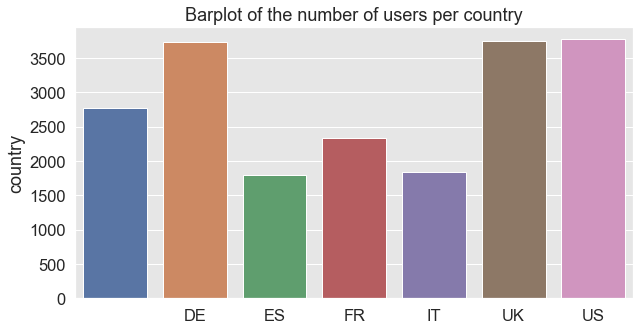

In [111]:
# Draw a barplot to check the distribution of the countries
f, ax = plt.subplots(1,1, figsize=(10, 5))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
ax = sns.barplot(data['country'].value_counts().index, data['country'].value_counts())
ax.set_title('Barplot of the number of users per country')


Despite the missing tag, the distribution of the country variable shows that each country has comparable users. Thus, the missing tag can not be discarded. We need to check with the data engineering team about this bug. At the meantime, let's analyze which country this missing tag could be.
* We have the UNIX time stamp of when each session started. UXIX time stamp can be converted into datetime (our action_date variable) in UTC time zone. By ploting the time of sessions started per country during a day, we can have a guess for the time zone based on the hours when most activities happen.

In [126]:
# Let's extract the hour element from the action date
data['hour'] = data['action_date'].dt.hour

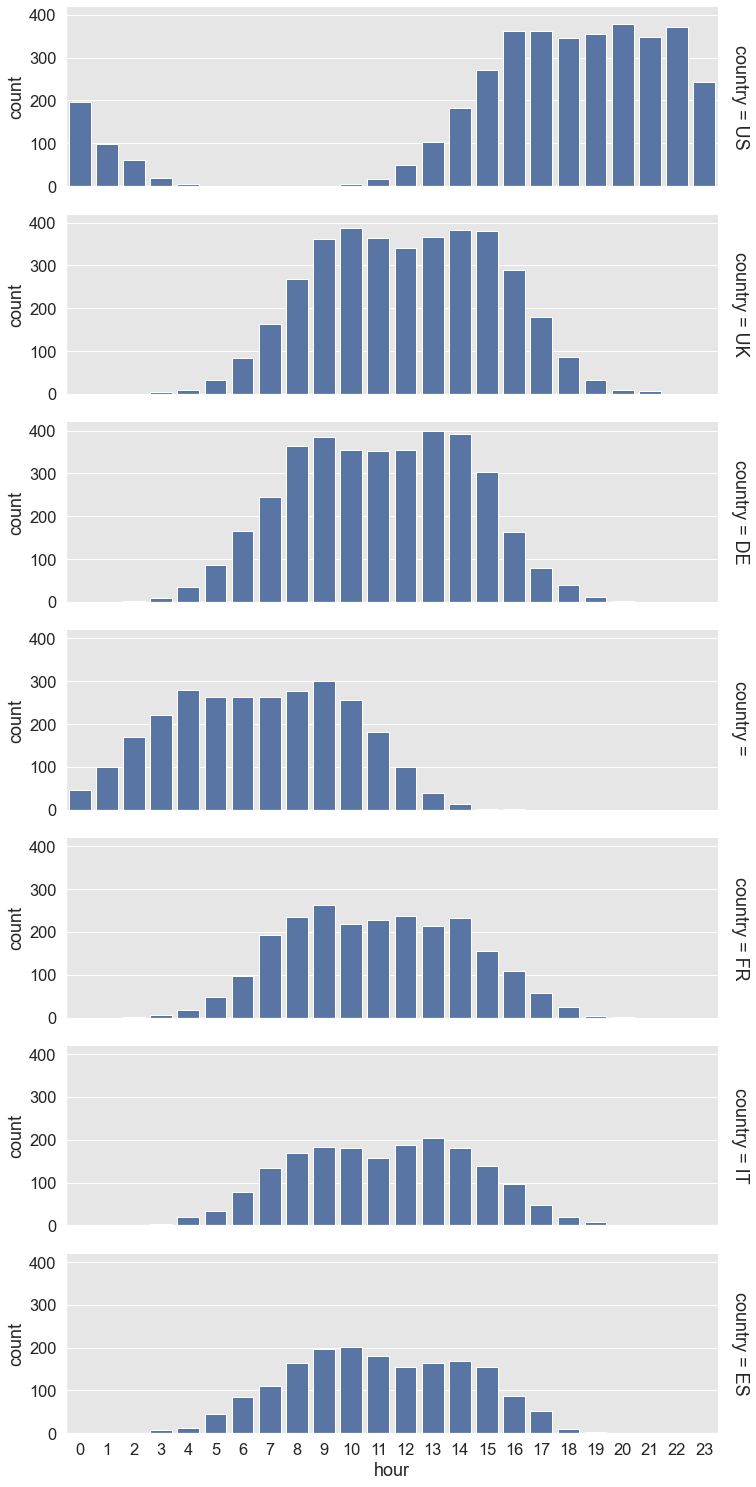

In [132]:
g = sns.FacetGrid(data, row="country", row_order=data.country.value_counts().index, margin_titles = True)
g.map(sns.countplot,'hour', order = range(24))
g.fig.set_figwidth(20)
plt.show()



The peak time for Western European countries is during 8AM-3PM. The country that is missing has a peak time during 3AM-10AM UTC, which is supposed to be a country that's five hours earlier than UTC time zone (UTC+05:00). Based on this, our guess for this country is it could be India, Pakistan, or some other country in the UTC+05:00 time zone.

After reaching out to the data engineering team, the missing country tag is only from one country, and it was confirmed to be India.

In [139]:
# Let's fill in the missing country.
data['country'].cat.rename_categories(lambda x: 'IN' if x == '' else x, inplace = True)

In [140]:
data.head()

,session_id,unix_timestamp,cities,user_id,joining_date,country,action_date,hour
0,D258NVMV202LS,1442640552,"San Jose CA, Montreal QC",5749,2015-04-02,FR,2015-09-19 05:29:12,5
1,TDG10UKG7I4LR,1432110137,New York NY,10716,2015-03-30,DE,2015-05-20 08:22:17,8
2,OH4ZDIGN9BLQS,1437049311,"Montreal QC, Quebec QC",2941,2015-03-16,IN,2015-07-16 12:21:51,12
3,CWHIAYKQ7RA28,1432215908,Chicago IL,2164,2015-03-27,FR,2015-05-21 13:45:08,13
4,GI8GZJAWAC80P,1443556226,"Toronto ON, Houston TX",10493,2015-03-31,US,2015-09-29 19:50:26,19


## Feature engineering
The goal of this project is to identify a subgroup of the website traffic that is more likely to be planning a recent trip than just casually browsing. Our strategy is that if a user search cities that are close to each other, then the user is more likely to be planning a recent trip. Now we need to construct some variables for each session regarding how 'close' the cities to each other.

There are two ways to define the distance between cities:
1. **Geographical distance**: With some online map API, we can get the latitude and longitude of each city, then calculate the actual distance between the cities searched in a session.
2. **Co-search distance**: Based on how often the cities are searched together in the same session, we can build a similarity matrix across all cities. Specifically, we use cosine similarity between each city. The co-search distance is then calculated using the cosine similarity matrix for the cities searched in a session.

We are going to construct these two distances for all the cities, then deploy a clustering alogorithm based on how close the cities searched in the same session to group users' session.

1. Geographical distance
* (1) First, we extract a list of unique cities being searched by users.
* (2) Second, since we are going to use an online map API to retrieve the latitude and longitude of each city, we need to preprocess the city names so they can be taken by the API.
* (3) Third, we will use the online map API to get all the latitude and longitude of each city.
* (4) Forth, build a function to calculate the geographical distance between two cities using their coordinates.
* (5) Fifth, construct a distance matrix across all the cities to store the geographical distance between each city.
* (6) Sixth, define a function to look up the distance between two cities in the matrix
* (7) Finally, calculate the average geographical distance between cities searched in every session.

In [143]:
# (1) Extract a list of unique cities from the 'cities' variable
# let's create a vector of all cities searched
cities = data['cities'].str.split(', ', expand = True).stack().reset_index(drop = True)


In [152]:
# get the unique cities
unique_cities = cities.unique()
unique_cities

array(['San Jose CA', 'Montreal QC', 'New York NY', 'Quebec QC',
       'Chicago IL', 'Toronto ON', 'Houston TX', 'Los Angeles CA',
       'San Diego CA', 'Santa Ana CA', 'Saint Catharines-Niagara ON',
       'Edmonton AB', 'Philadelphia PA', 'Vancouver BC', 'Detroit MI',
       'Phoenix AZ', 'Calgary AB', 'Jersey City NJ', 'Newark NJ',
       'Columbus OH', 'Portland OR', 'Austin TX', 'Boston MA',
       'Buffalo NY', 'Anaheim CA', 'Indianapolis IN', 'OTTAWA ON',
       'Riverside CA', 'Long Beach CA', 'Toledo OH', 'San Antonio TX',
       'Jacksonville FL', 'Baltimore MD', 'Hamilton ON', 'Seattle WA',
       'Victoria BC', 'Corpus Christi TX', 'Miami FL', 'Hialeah FL',
       'Saint Petersburg FL', 'Tampa FL', 'Glendale AZ', 'Milwaukee WI',
       'Madison WI', 'Dallas TX', 'WASHINGTON DC', 'Stockton CA',
       'San Francisco CA', 'Oshawa ON', 'Arlington TX', 'Chandler AZ',
       'Louisville KY', 'Plano TX', 'Mesa AZ', 'Kitchener ON',
       'Cincinnati OH', 'Chesapeake VA', 'Virgi

It seems that the desinations from the sessions data we got are a group of cities in the U.S. and Canana.

In [153]:
# convert it to a list
unique_cities = unique_cities.tolist()

For the online map API, we pick the **OpenStreetMap Nominatim API**. https://nominatim.org/release-docs/latest/api/Search/
* The format of the API is:
    * https://nominatim.openstreetmap.org/search?<params>&format=geojson
    * Example: https://nominatim.openstreetmap.org/search?q=17+Strada+Pictor+Alexandru+Romano%2C+Bukarest&format=geojson
* We choose the result of each query to be in **JSON**.


In [155]:
#(2) Change the city names so it can be used in the API
# According to the API format, we need to replace the spaces in city names with '+'
unique_cities = [city.replace(' ', '+') for city in unique_cities]


In [157]:
unique_cities[0:10]

['San+Jose+CA',
 'Montreal+QC',
 'New+York+NY',
 'Quebec+QC',
 'Chicago+IL',
 'Toronto+ON',
 'Houston+TX',
 'Los+Angeles+CA',
 'San+Diego+CA',
 'Santa+Ana+CA']

The city names are in the right format for the API. Let's now use the API.

In [179]:
# (3) Utilize the API to get the latitude and longitude of each city
# Define a function to get the latitude and longitude of each city
# We use a public API from Openstreetmap


def get_lat_long(city):
    # Give a break of 5 second to avoid overloading the server
    time.sleep(5)
    # Create the url
    url = 'https://nominatim.openstreetmap.org/search?q={}&format=json&limit=1'.format(city)
    response = requests.get(url)
    api_result = json.loads(response.text)
    try:
        lat = float(api_result[0]['lat'])
        long = float(api_result[0]['lon'])
    except:
        lat = np.nan
        long = np.nan
        print("Data is not available for {}.".format(city) )
    return lat, long

In [180]:
# Let's test the function
print(unique_cities[0])
get_lat_long(unique_cities[0])


San+Jose+CA


(37.3361663, -121.890591)

In [181]:
# It works! Let's apply the function to the list of unique cities
lat_long = [get_lat_long(city) for city in unique_cities]

In [185]:
# let's contruct a dictionary of the cities and their latitude and longitude
# change the name of the cities back to the original format
unique_cities = [city.replace('+', ' ') for city in unique_cities]
lat_long_dict = dict(zip(unique_cities, lat_long))

In [186]:
lat_long_dict

{'San Jose CA': (37.3361663, -121.890591),
 'Montreal QC': (45.5031824, -73.5698065),
 'New York NY': (40.7127281, -74.0060152),
 'Quebec QC': (46.8137431, -71.2084061),
 'Chicago IL': (41.8755616, -87.6244212),
 'Toronto ON': (43.6534817, -79.3839347),
 'Houston TX': (29.7589382, -95.3676974),
 'Los Angeles CA': (34.0536909, -118.242766),
 'San Diego CA': (32.7174202, -117.1627728),
 'Santa Ana CA': (33.7494951, -117.8732213),
 'Saint Catharines-Niagara ON': (43.1579812, -79.2441003),
 'Edmonton AB': (53.5462055, -113.491241),
 'Philadelphia PA': (39.9527237, -75.1635262),
 'Vancouver BC': (49.2608724, -123.113952),
 'Detroit MI': (42.3315509, -83.0466403),
 'Phoenix AZ': (33.4484367, -112.074141),
 'Calgary AB': (51.0460954, -114.065465),
 'Jersey City NJ': (40.7215682, -74.047455),
 'Newark NJ': (40.735657, -74.1723667),
 'Columbus OH': (39.9622601, -83.0007065),
 'Portland OR': (45.5202471, -122.674194),
 'Austin TX': (30.2711286, -97.7436995),
 'Boston MA': (42.3554334, -71.060511

In [199]:
# (4) Let's define a function to calculate the geographical distance between two cities
# We use the Haversine formula to calculate the distance between two points on a sphere (Earth)
# The Haversine formula is: d = 2r * arcsin(sqrt(sin^2((lat2 - lat1)/2) + cos(lat1)cos(lat2)sin^2((long2 - long1)/2)))
# where r is the radius of the Earth, which is 6371 km
# The latitude and longitude are in radians

def get_distance(city1, city2):
    # This function takes the name of two cities and returns the distance between them in km
    
    r = 6371
    # Convert degrees to radians
    lat1 =  lat_long_dict[city1][0] * np.pi / 180
    lat2 = lat_long_dict[city2][0] * np.pi / 180
    long1 = lat_long_dict[city1][1] * np.pi / 180
    long2 = lat_long_dict[city2][1] * np.pi / 180
    d = 2 * r * np.arcsin(np.sqrt(np.sin((lat2 - lat1)/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin((long2 - long1)/2)**2))
    return d

In [200]:
# Let's test the function
get_distance('New York NY', 'Los Angeles CA')

3935.5992910107525

Let's verify if the function gets the correct distance between New York and Los Angeles.
<img src="img/ny_la_distance.png" width="700" height="300">

It worked! Here we use the direct distance between two cities.


In [201]:
# (5) Let's contruct a matrix of the distances between cities

def create_distance_matrix(lat_long_dict):
    # This function takes a dictionary of cities and their latitude and longitude and returns a matrix of distances between cities in km
    
    # Initialize a matrix to store the distances
    distance_matrix = np.zeros((len(lat_long_dict), len(lat_long_dict)))

    # Get the list of city names
    city_names = list(lat_long_dict.keys())

    # Loop over all pairs of cities
    for i in range(len(lat_long_dict)):
        for j in range(len(lat_long_dict)):
            # Calculate the distance between the two cities
            city1 = city_names[i]
            city2 = city_names[j]
            distance = get_distance(city1, city2)

            # Store the distance in the matrix
            distance_matrix[i, j] = distance

    return distance_matrix, city_names



In [202]:
distance_matrix, city_names = create_distance_matrix(lat_long_dict)

In [203]:
print(city_names)
print(distance_matrix)

['San Jose CA', 'Montreal QC', 'New York NY', 'Quebec QC', 'Chicago IL', 'Toronto ON', 'Houston TX', 'Los Angeles CA', 'San Diego CA', 'Santa Ana CA', 'Saint Catharines-Niagara ON', 'Edmonton AB', 'Philadelphia PA', 'Vancouver BC', 'Detroit MI', 'Phoenix AZ', 'Calgary AB', 'Jersey City NJ', 'Newark NJ', 'Columbus OH', 'Portland OR', 'Austin TX', 'Boston MA', 'Buffalo NY', 'Anaheim CA', 'Indianapolis IN', 'OTTAWA ON', 'Riverside CA', 'Long Beach CA', 'Toledo OH', 'San Antonio TX', 'Jacksonville FL', 'Baltimore MD', 'Hamilton ON', 'Seattle WA', 'Victoria BC', 'Corpus Christi TX', 'Miami FL', 'Hialeah FL', 'Saint Petersburg FL', 'Tampa FL', 'Glendale AZ', 'Milwaukee WI', 'Madison WI', 'Dallas TX', 'WASHINGTON DC', 'Stockton CA', 'San Francisco CA', 'Oshawa ON', 'Arlington TX', 'Chandler AZ', 'Louisville KY', 'Plano TX', 'Mesa AZ', 'Kitchener ON', 'Cincinnati OH', 'Chesapeake VA', 'Virginia Beach VA', 'Lexington KY', 'Fort Worth TX', 'Sacramento CA', 'Oakland CA', 'Fresno CA', 'Nashville T

In [204]:
# (6) define a function to look up the distance between two cities in the matrix
def get_distance_matrix(city1, city2, distance_matrix, city_names):
    # This function takes the name of two cities and returns the distance between them in km
    
    # Get the index of the two cities
    city1_index = city_names.index(city1)
    city2_index = city_names.index(city2)
    
    # Get the distance between the two cities
    distance = distance_matrix[city1_index, city2_index]
    
    return distance


In [205]:
# Let's test the function
get_distance_matrix('New York NY', 'Los Angeles CA', distance_matrix, city_names)

3935.5992910107525

It works! 

(7) Now we can use this function to calculate the **average distance** between all pairwise combinations of cities searched in a session.
* If there is only one city searched in a session, we discard the records. We don’t have enough info now to assign them to either low or high intent of booking a hotel.
* If there are two cities searched in a session, we calculate the distance between the two cities.
* If there are more than two cities, we get all combinations of a pair of two cities, then calculate the distance between each combination, sum them up, then divided by the number of combinations.
    * If there are 3 cities, then the number of unique pairs of two cities is 3!/(2!*(3-2)!) = 3.
    * If there are 4 cities, then the number of unique pairs of two cities is 4!/(2!*(4-2)!) = 6.
    * ...
    * If there are n cities, then the number of unique pairs of two cities is n!/(2!*(n-2)!)

**Metric selection**:
* The metric we use is the average distance, not the median or other percentile-based metric, because we want our metric to be sensitive to outliers. Average distance will be affected more than percentile-based metric if there is at one city is far away from others. When there is at least one city far away from others, it is not likely from a user who is planning a recent trip. We want our metric to be sensitive to this situation.

In [206]:
# Remove the sessions that only have one city searched
data['city_count'] = data['cities'].apply(lambda x: x.count(',') + 1)

In [208]:
data.head()

,session_id,unix_timestamp,cities,user_id,joining_date,country,action_date,hour,city_count
0,D258NVMV202LS,1442640552,"San Jose CA, Montreal QC",5749,2015-04-02,FR,2015-09-19 05:29:12,5,2
1,TDG10UKG7I4LR,1432110137,New York NY,10716,2015-03-30,DE,2015-05-20 08:22:17,8,1
2,OH4ZDIGN9BLQS,1437049311,"Montreal QC, Quebec QC",2941,2015-03-16,IN,2015-07-16 12:21:51,12,2
3,CWHIAYKQ7RA28,1432215908,Chicago IL,2164,2015-03-27,FR,2015-05-21 13:45:08,13,1
4,GI8GZJAWAC80P,1443556226,"Toronto ON, Houston TX",10493,2015-03-31,US,2015-09-29 19:50:26,19,2


In [209]:
# Only keep the sessions that have more than one city searched
data_multiple_cities = data[data['city_count'] > 1].reset_index(drop = True)

In [211]:
# Define a function to calculate the average distance between all the cities in a session
def get_average_distance(cities):
    # This function takes a string of cities and returns the average distance between them in km
    
    # Split the string of cities into a list
    cities = cities.split(', ')
    
    # Initialize a list to store the distances between all pairs of cities
    distances = []
    
    # Loop over all pairs of cities
    
    # Get all pairwise combinations of cities
    cities_combinations = list(itertools.combinations(cities, 2))

    # Loop over all pairs of cities
    for pair in cities_combinations:
        # Calculate the distance between the two cities
        distance = get_distance_matrix(pair[0], pair[1], distance_matrix, city_names)
            
        # Store the distance in the list
        distances.append(distance)
    
    # Calculate the average distance
    average_distance = np.mean(distances)
    
    return average_distance

In [213]:
# Let's test the function
get_average_distance('San Diego CA, Los Angeles CA, Santa Ana CA')

119.90389112317985

In [214]:
# let's calculate the average distance for this example
# There are 3 pairs of cities
# San Diego CA, Los Angeles CA
distance_01 = get_distance_matrix('San Diego CA', 'Los Angeles CA', distance_matrix, city_names)
# San Diego CA, Santa Ana CA
distance_02 = get_distance_matrix('San Diego CA', 'Santa Ana CA', distance_matrix, city_names)
# Los Angeles CA, Santa Ana CA
distance_03 = get_distance_matrix('Los Angeles CA', 'Santa Ana CA', distance_matrix, city_names)
# The average distance is the mean of the three distances
average_distance_example = np.mean([distance_01, distance_02, distance_03])
average_distance_example


119.90389112317985

Our function has the same result as our calculation! The function works. Let's calculate the average distance for all the sessions.

In [227]:
# Let's apply the function to the data set
data_multiple_cities['average_geo_distance'] = data_multiple_cities['cities'].apply(lambda x: get_average_distance(x))

In [228]:
data_multiple_cities.head()

,session_id,unix_timestamp,cities,user_id,joining_date,country,action_date,hour,city_count,average_geo_distance
0,D258NVMV202LS,1442640552,"San Jose CA, Montreal QC",5749,2015-04-02,FR,2015-09-19 05:29:12,5,2,4066.124637
1,OH4ZDIGN9BLQS,1437049311,"Montreal QC, Quebec QC",2941,2015-03-16,IN,2015-07-16 12:21:51,12,2,233.039406
2,GI8GZJAWAC80P,1443556226,"Toronto ON, Houston TX",10493,2015-03-31,US,2015-09-29 19:50:26,19,2,2094.272442
3,5FWYK13BT295Y,1439889752,"San Diego CA, Santa Ana CA",8056,2015-03-19,FR,2015-08-18 09:22:32,9,2,132.424207
4,PWERIG07P4511,1442414804,"Toronto ON, Saint Catharines-Niagara ON",9705,2015-03-07,DE,2015-09-16 14:46:44,14,2,56.243218


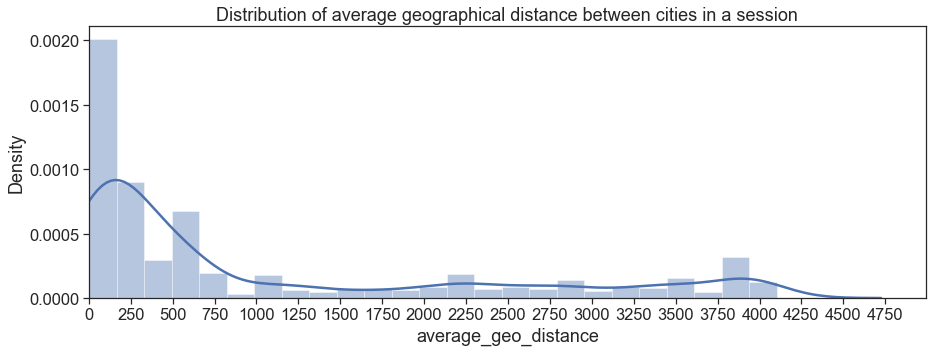

In [230]:
#Let's plot distance distribution 
f, ax = plt.subplots(1,1, figsize=(15, 5))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
ax = sns.distplot(data_multiple_cities['average_geo_distance'])
ax.set_title('Distribution of average geographical distance between cities in a session')
# Let the x-axis start at 0
ax.set_xlim(0, )
# Show more ticks on the x-axis
ax.xaxis.set_major_locator(plt.MaxNLocator(20))

plt.show()

We see the distribution of average geographical distance between cities in a session is **right-skewed**. Most of the sessions have an average geographical distance around 200 km. There are few sessions have average geographical distances that all the way to around 4000 km.

Here we finished the calculation of geographical distance. It is saved in the column 'average_geo_distance', and will be used for clustering analysis later.

Now let's calculate another distance.

2.**Co-search distance**

Sometimes when a user plans a trip, they have more than one city to visit. The user could make a stop in a city that is still far from their other destination. That is, a user might make a stop in Dubai before they go to Singapore. This situation will not be targeted if we just use the average geographical distance metric, because the cities searched in a session are too far from each other. 

To address this situation, we use a co-search distance. This applies even when some cities are far from each other. The assumption is that when users search for these distant cities together in a session, they are still likely planning a recent trip.

Based on how often the cities are searched together in the same session, we can build a similarity matrix across all cities. Specifically, we use cosine similarity between each city. The co-search distance is then calculated using the cosine similarity matrix for the cities searched in a session.
* For example, many users search Las Vegas and Los Angeles together, but do not search Las Vegas and Seattle together that often. Therefore, Las Vegas should have way higher cosine similarity with Los Angeles than Seattle. 

Co-search distance:
* (1) First, let's extract the cities searched within a session and save it into city-session_id pairs.
* (2) Second, construct a vector. This vector will include all the unique cities and indicate if they were searched for in the same sequence as they appear in an exhaustive list of unique sessions
* (3) Third, calculate the cosine similarity (**the co-search distance**) between each city.
* (4) Finally, calculate the average co-search distance between cities searched for each session.

In [262]:
# (1) Extract the cities searched within each session
data.head()

,session_id,unix_timestamp,cities,user_id,joining_date,country,action_date,hour,city_count
0,D258NVMV202LS,1442640552,"San Jose CA, Montreal QC",5749,2015-04-02,FR,2015-09-19 05:29:12,5,2
1,TDG10UKG7I4LR,1432110137,New York NY,10716,2015-03-30,DE,2015-05-20 08:22:17,8,1
2,OH4ZDIGN9BLQS,1437049311,"Montreal QC, Quebec QC",2941,2015-03-16,IN,2015-07-16 12:21:51,12,2
3,CWHIAYKQ7RA28,1432215908,Chicago IL,2164,2015-03-27,FR,2015-05-21 13:45:08,13,1
4,GI8GZJAWAC80P,1443556226,"Toronto ON, Houston TX",10493,2015-03-31,US,2015-09-29 19:50:26,19,2


In [263]:
# Split the string of cities into a list and save it as a city-session data frame
city_session = pd.DataFrame(data['cities'].str.split(', ').tolist(), index = data['session_id']).stack()


In [264]:
# Reset the index and save the index as a column
city_session = city_session.reset_index([0, 'session_id'])

In [265]:
# Name the columns
city_session.columns = ['session_id', 'city']


In [266]:
city_session.head()

,session_id,city
0,D258NVMV202LS,San Jose CA
1,D258NVMV202LS,Montreal QC
2,TDG10UKG7I4LR,New York NY
3,OH4ZDIGN9BLQS,Montreal QC
4,OH4ZDIGN9BLQS,Quebec QC


In [267]:
# (2) Construct a vector of cities searched in each session
city_session['binary_value'] = 1
city_session = city_session.pivot(index = 'session_id', columns = 'city', values = 'binary_value').fillna(0)


In [269]:
city_session.head()

city,Anaheim CA,Arlington TX,Atlanta GA,Austin TX,Bakersfield CA,...,Victoria BC,Virginia Beach VA,WASHINGTON DC,Wichita KS,Windsor ON
session_id,,,,,,,,,,,
005DKBSO9FEZL,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
006EM84U68V9I,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
009CAJV5IDV7Q,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
00AR2ULVTS3JY,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0
00B1MRZFC6KZM,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0


In [270]:
city_session.shape

(20022, 87)

In [282]:
# Let's check the record of a session and shows the columns that have a value of 1
city_session.loc['D258NVMV202LS', city_session.loc['D258NVMV202LS'] == 1]

city
Montreal QC    1.0
San Jose CA    1.0
Name: D258NVMV202LS, dtype: float64

In [283]:
data.loc[data['session_id'] == 'D258NVMV202LS', 'cities']

0    San Jose CA, Montreal QC
Name: cities, dtype: object

The vector returns the same result as the original data frame, which means the vector is correctly built.

In [285]:
# (3) Calculate the cosine similarity between cities
city_cosine = pd.DataFrame(metrics.pairwise.cosine_similarity(city_session.T))
# Add the city names as the index and column names
city_cosine.columns = city_session.columns
city_cosine.index = city_session.columns


In [287]:
city_cosine

city,Anaheim CA,Arlington TX,Atlanta GA,Austin TX,Bakersfield CA,...,Victoria BC,Virginia Beach VA,WASHINGTON DC,Wichita KS,Windsor ON
city,,,,,,,,,,,
Anaheim CA,1.000000,0.000000,0.0,0.000000,0.057921,...,0.0,0.000000,0.000000,0.000000,0.0
Arlington TX,0.000000,1.000000,0.0,0.235702,0.000000,...,0.0,0.000000,0.000000,0.066667,0.0
Atlanta GA,0.000000,0.000000,1.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0
Austin TX,0.000000,0.235702,0.0,1.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0
Bakersfield CA,0.057921,0.000000,0.0,0.000000,1.000000,...,0.0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
Victoria BC,0.000000,0.000000,0.0,0.000000,0.000000,...,1.0,0.000000,0.000000,0.000000,0.0
Virginia Beach VA,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,1.000000,0.290191,0.000000,0.0
WASHINGTON DC,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.290191,1.000000,0.000000,0.0


In [ ]:
# define a dictionary to store the cosine similarity between cities like (city1, city2):similarity_score
city_cosine_dict = city_cosine.unstack().to_dict()



In [364]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
from branca.element import Template, MacroElement

# Create a map centered around North America
m = folium.Map(location=[40.0000, -100.0000], zoom_start=4)

# Define the color map
norm = colors.Normalize(vmin=min(city_cosine_dict.values()), vmax=max(city_cosine_dict.values()))
cmap = cm.get_cmap("jet")

# Draw lines between pairs of cities and add city markers
for (city1, city2), similarity_score in city_cosine_dict.items():
   # Get the coordinates of the two cities
    coord1 = lat_long_dict[city1]
    coord2 = lat_long_dict[city2]

    # Assign transparency based on similarity_score, higher similarity_score has less transparency
    alpha = int((1 - similarity_score) * 255)

    # Assign the color blue
    rgb_color = [0, 0, 255]

    # Convert the RGB values to a string format accepted by folium
    color = "#{:02x}{:02x}{:02x}{:02x}".format(rgb_color[0], rgb_color[1], rgb_color[2], alpha)

    # Draw a line between the two cities
    folium.PolyLine(locations=[coord1, coord2], color=color, weight=4.5, opacity=similarity_score).add_to(m)


# Add city markers
for city, coords in lat_long_dict.items():
    folium.Marker(location=coords, popup=city, icon=folium.Icon(color="blue")).add_to(m)

template = """
{% macro html(this, kwargs) %}
<div style="position: fixed; 
            bottom: 50px; 
            left: 50px; 
            width: 300px; 
            height: 90px; 
            border:2px solid grey; 
            z-index:9999; 
            font-size:14px;
            ">
    <p><a style="color:#000000;font-size:150%;">&nbsp;Similarity score legend</a></p>
    <div style="
            width: 100%; 
            height: 15px; 
            border:1px solid grey; 
            z-index:9999; 
            background: linear-gradient(to right, rgba(0,0,255,0) 0%, rgba(0,0,255,1) 100%);">
    </div>
    <p style="padding-top: 10px;">
        <span style="float: left;">0.0</span>
        <span style="float: right;">1.0</span>
        <span style="width: 20%; display: inline-block; text-align: center;">0.2</span>
        <span style="width: 20%; display: inline-block; text-align: center;">0.4</span>
        <span style="width: 20%; display: inline-block; text-align: center;">0.6</span>
        <span style="width: 20%; display: inline-block; text-align: center;">0.8</span>
    </p>
</div>
{% endmacro %}
"""

macro = MacroElement()
macro._template = Template(template)

m.get_root().add_child(macro)

# Display the map
m

<img src="img/map_screenshot.png" width="1000" height="600">

The map shows the similarity score between every city. That is, how often they will be searched together in a session.
* The similarity score ranges from 0.0 to 1.0. The larger the score, the more often the two cities are being searched together in a session. 1.0 means the two cities appear together in every session, while 0.0 means the two cities are not being searched together at all. The deeper the blue color shows the larger similarity score.
* It validates the idea that even some cities are far from each other, they still appear in the same session.
    * Minneapolis, MN and Madison, WI have the similary similarity score with New York City and Philadelphia. Even though the first pair of cities have larger distance.
* The map shows cities are searched together more if they are from the same region, e.g. Pacific NorthWest, Upper MidWest and the NY-NJ-CT tri-state area.

<img src="img/map_pnw.png" width="600" height="360">
<img src="img/map_eastus.png" width="600" height="360">

* With the similarity score (co-search distance), we can identify the cities that have a large distance from each other, but still considered together by trip planners.
* We will use both the co-search distance and the geographical distance to identify the cities that are searched together by users and they are not too far from each other. We will use clustering method for this purpose. 

In [365]:
data_multiple_cities.head()

,session_id,unix_timestamp,cities,user_id,joining_date,country,action_date,hour,city_count,average_geo_distance
0,D258NVMV202LS,1442640552,"San Jose CA, Montreal QC",5749,2015-04-02,FR,2015-09-19 05:29:12,5,2,4066.124637
1,OH4ZDIGN9BLQS,1437049311,"Montreal QC, Quebec QC",2941,2015-03-16,IN,2015-07-16 12:21:51,12,2,233.039406
2,GI8GZJAWAC80P,1443556226,"Toronto ON, Houston TX",10493,2015-03-31,US,2015-09-29 19:50:26,19,2,2094.272442
3,5FWYK13BT295Y,1439889752,"San Diego CA, Santa Ana CA",8056,2015-03-19,FR,2015-08-18 09:22:32,9,2,132.424207
4,PWERIG07P4511,1442414804,"Toronto ON, Saint Catharines-Niagara ON",9705,2015-03-07,DE,2015-09-16 14:46:44,14,2,56.243218


In [366]:
# (4) Calculate the average cosine similarity between cities in a session  
# Let's keep only the sessions that have more than one city searched
data_multiple_cities
# Define a function to calculate the average cosine similarity between cities in a session
def get_average_cosine_similarity(cities):
    # This function takes a string of cities and returns the average cosine similarity between them
    
    # Split the string of cities into a list
    cities = cities.split(', ')
    
    # Initialize a list to store the cosine similarities between all pairs of cities
    cosine_similarities = []
    
    # Loop over all pairs of cities
    
    # Get all pairwise combinations of cities
    cities_combinations = list(itertools.combinations(cities, 2))

    # Loop over all pairs of cities
    for pair in cities_combinations:
        # Calculate the cosine similarity between the two cities
        cosine_similarity = city_cosine.loc[pair[0], pair[1]]
            
        # Store the cosine similarity in the list
        cosine_similarities.append(cosine_similarity)
    
    # Calculate the average cosine similarity
    average_cosine_similarity = np.mean(cosine_similarities)
    
    return average_cosine_similarity





In [368]:
# Let's test the function
get_average_cosine_similarity('San Diego CA, Los Angeles CA, Santa Ana CA')

0.1889392435963869

In [369]:
# let's calculate the average cosine similarity for this example
# There are 3 pairs of cities
# San Diego CA, Los Angeles CA
cosine_similarity_01 = city_cosine.loc['San Diego CA', 'Los Angeles CA']
# San Diego CA, Santa Ana CA
cosine_similarity_02 = city_cosine.loc['San Diego CA', 'Santa Ana CA']
# Los Angeles CA, Santa Ana CA
cosine_similarity_03 = city_cosine.loc['Los Angeles CA', 'Santa Ana CA']
# The average cosine similarity is the mean of the three cosine similarities
average_cosine_similarity_example = np.mean([cosine_similarity_01, cosine_similarity_02, cosine_similarity_03])
average_cosine_similarity_example

0.1889392435963869

The function returns the same answer as our manual calculation! This means the function is working.

In [370]:
# Let's apply the function to the data set
data_multiple_cities['average_cosine_similarity'] = data_multiple_cities['cities'].apply(lambda x: get_average_cosine_similarity(x))

In [371]:
data_multiple_cities.head()

,session_id,unix_timestamp,cities,user_id,joining_date,...,action_date,hour,city_count,average_geo_distance,average_cosine_similarity
0,D258NVMV202LS,1442640552,"San Jose CA, Montreal QC",5749,2015-04-02,...,2015-09-19 05:29:12,5,2,4066.124637,0.016692
1,OH4ZDIGN9BLQS,1437049311,"Montreal QC, Quebec QC",2941,2015-03-16,...,2015-07-16 12:21:51,12,2,233.039406,0.216506
2,GI8GZJAWAC80P,1443556226,"Toronto ON, Houston TX",10493,2015-03-31,...,2015-09-29 19:50:26,19,2,2094.272442,0.052971
3,5FWYK13BT295Y,1439889752,"San Diego CA, Santa Ana CA",8056,2015-03-19,...,2015-08-18 09:22:32,9,2,132.424207,0.282433
4,PWERIG07P4511,1442414804,"Toronto ON, Saint Catharines-Niagara ON",9705,2015-03-07,...,2015-09-16 14:46:44,14,2,56.243218,0.273372


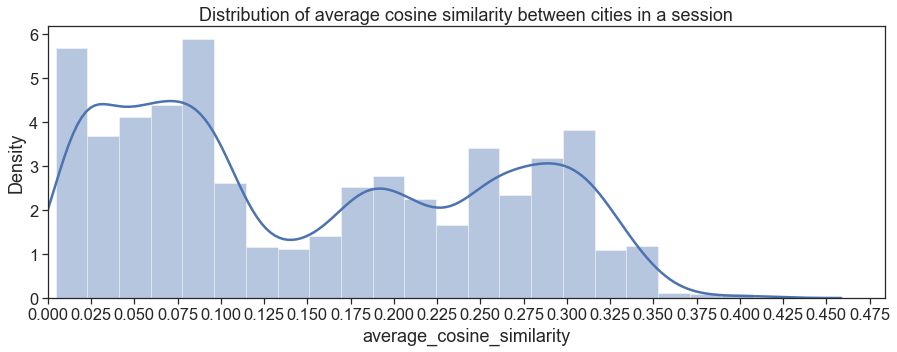

In [372]:
# Let's plot the distribution of the average cosine similarity
f, ax = plt.subplots(1,1, figsize=(15, 5))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
ax = sns.distplot(data_multiple_cities['average_cosine_similarity'])
ax.set_title('Distribution of average cosine similarity between cities in a session')
# Let the x-axis start at 0
ax.set_xlim(0, )
# Show more ticks on the x-axis
ax.xaxis.set_major_locator(plt.MaxNLocator(20))


In [373]:
print("0.125 represents the ", round(scipy.stats.percentileofscore(data_multiple_cities['average_cosine_similarity'], 0.1), 1), "th ", "percentile", sep="")

0.125 represents the 43.8th percentile


There is a discontinuity around 0.125, which means the session can be grouped into two clusters simply using the average cosine similarity. This is promising for applying the clustering method, which intends to group the cities based on some criteria.

## Data modeling
We will cluster sessions, look into the cluster characteristics.
The variables we will use are:
* city_count: the number of cities searched in a session
* average_geo_distance: the average geographical distance between the cities searched in a session
* average_cosine_similarity: the average co-search distance between the cities searched in a session

In [415]:
data_multiple_cities.head()

,session_id,unix_timestamp,cities,user_id,joining_date,...,action_date,hour,city_count,average_geo_distance,average_cosine_similarity
0,D258NVMV202LS,1442640552,"San Jose CA, Montreal QC",5749,2015-04-02,...,2015-09-19 05:29:12,5,2,4066.124637,0.016692
1,OH4ZDIGN9BLQS,1437049311,"Montreal QC, Quebec QC",2941,2015-03-16,...,2015-07-16 12:21:51,12,2,233.039406,0.216506
2,GI8GZJAWAC80P,1443556226,"Toronto ON, Houston TX",10493,2015-03-31,...,2015-09-29 19:50:26,19,2,2094.272442,0.052971
3,5FWYK13BT295Y,1439889752,"San Diego CA, Santa Ana CA",8056,2015-03-19,...,2015-08-18 09:22:32,9,2,132.424207,0.282433
4,PWERIG07P4511,1442414804,"Toronto ON, Saint Catharines-Niagara ON",9705,2015-03-07,...,2015-09-16 14:46:44,14,2,56.243218,0.273372


In [428]:
# Only keep the variables that we need
data_cluster = data_multiple_cities[['city_count','average_geo_distance', 'average_cosine_similarity']]
# Standardize the variables
data_scaler = StandardScaler()
data_scaler.fit(data_cluster)
data_cluster_scaled = pd.DataFrame(data_scaler.transform(data_cluster), columns=data_cluster.columns)


In [ ]:
#data_scaler.inverse_transform(data_cluster_scaled)
#Scale back the data to the original representation.

In [429]:
# Remove the missing values
data_cluster_scaled = data_cluster_scaled.dropna()

In [430]:
print(data_cluster_scaled.describe())

         city_count  average_geo_distance  average_cosine_similarity
count  9.469000e+03          9.469000e+03               9.469000e+03
mean   1.796242e-17          1.319277e-16               9.218052e-17
std    1.000053e+00          1.000053e+00               1.000053e+00
min   -5.049467e-01         -8.126508e-01              -1.401019e+00
25%   -5.049467e-01         -7.155672e-01              -8.689976e-01
50%   -5.049467e-01         -5.197545e-01              -2.587643e-01
75%    8.306232e-01          6.794792e-01               9.951280e-01
max    7.508473e+00          2.354679e+00               2.411752e+00


Now, let's proceed to clustering. The most common methods include k-means and hierarchical clustering. A good approach is to start with the simplest technique and move to more advanced ones only if necessary.

Given that our dataset is relatively simple, with few variables that are all numerical and on the same scale, k-means appears to be an appropriate choice.

In [431]:
from sklearn.cluster import KMeans 

In [432]:
#Clustering. Let's use the elbow method to get a sense of the optimal number of clusters.  
#i.e. sum of squared distances vs # of clusters 
sse = [] 
for i in range(2, 10):     
    sse.append(KMeans(n_clusters=i, init='k-means++', random_state=10).fit(data_cluster_scaled).inertia_)    


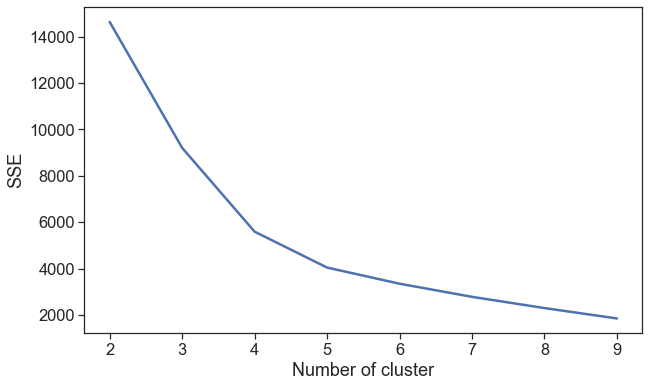

In [433]:
# Plot the elbow curve
plt.figure(figsize=(10, 6))

plt.plot(range(2,10), sse) 
plt.xlabel("Number of cluster") 
plt.ylabel("SSE") 
plt.show()

Looks like the optimal number of cluster is somewhere between 5 and 7. Let’s pick 7 and check the cluster characteristics.

In [434]:
clusters = KMeans(n_clusters=7, init='k-means++', random_state=10).fit(data_cluster_scaled)
  
#get cluster centroids
cluster_characteristics = pd.DataFrame(clusters.cluster_centers_, columns = data_cluster_scaled.columns)
  
#add cluster size and label
cluster_characteristics['size']=np.bincount(clusters.labels_)
cluster_characteristics['label']= range(0, clusters.n_clusters)
print(cluster_characteristics)

   city_count  average_geo_distance  average_cosine_similarity  size  label
0   -0.504947             -0.724586                   0.980325  2488      0
1   -0.281879              0.913846                  -1.093645  1413      1
2    2.166193             -0.655394                   0.793469   559      2
3    0.830623             -0.679164                   0.889282  1367      3
4   -0.504947              2.026990                  -0.969672  1309      4
5   -0.459770             -0.335370                  -0.666050  2099      5
6    3.992613             -0.611545                   0.488956   234      6


In [454]:
reverse_transformed_centroids = pd.DataFrame(data_scaler.inverse_transform(cluster_characteristics.iloc[:, 0:3]),
columns = data_cluster.columns)
reverse_transformed_centroids[['label', 'size']] = cluster_characteristics[['label', 'size']]

In [455]:
# Reverse the standardization of the variables
reverse_transformed_centroids

,city_count,average_geo_distance,average_cosine_similarity,label,size
0,2.000000,115.826554,0.256345,0,2488
1,2.167021,2236.965652,0.036974,1,1413
2,4.000000,205.402417,0.236581,2,559
3,3.000000,174.630171,0.246716,3,1367
4,2.000000,3678.059548,0.050087,4,1309
5,2.033826,619.711696,0.082202,5,2099
6,5.367521,262.170997,0.204372,6,234


In [469]:
#These are going to be our anomaly clusters: at least one absolute value larger than 2. 
anomaly_cluster = pd.melt(cluster_characteristics,id_vars=['label', 'size'],var_name='variable', value_name='value') 
anomaly_cluster = anomaly_cluster.query('abs(value)>2').sort_values("label") 

In [470]:
# Print the characteristics of the anomaly clusters in the original scale
anomaly_cluster.reset_index(drop=True, inplace=True)
print("Anomaly clusters:")
for i in range(anomaly_cluster.shape[0]):
    label = anomaly_cluster['label'][i]
    variable = anomaly_cluster['variable'][i]
    print("Cluster", label)
    print(variable, round(reverse_transformed_centroids.loc[reverse_transformed_centroids.label == label, variable].values[0],2) )
    print("\n")

Anomaly clusters:
Cluster 2
city_count 4.0


Cluster 4
average_geo_distance 3678.06


Cluster 6
city_count 5.37




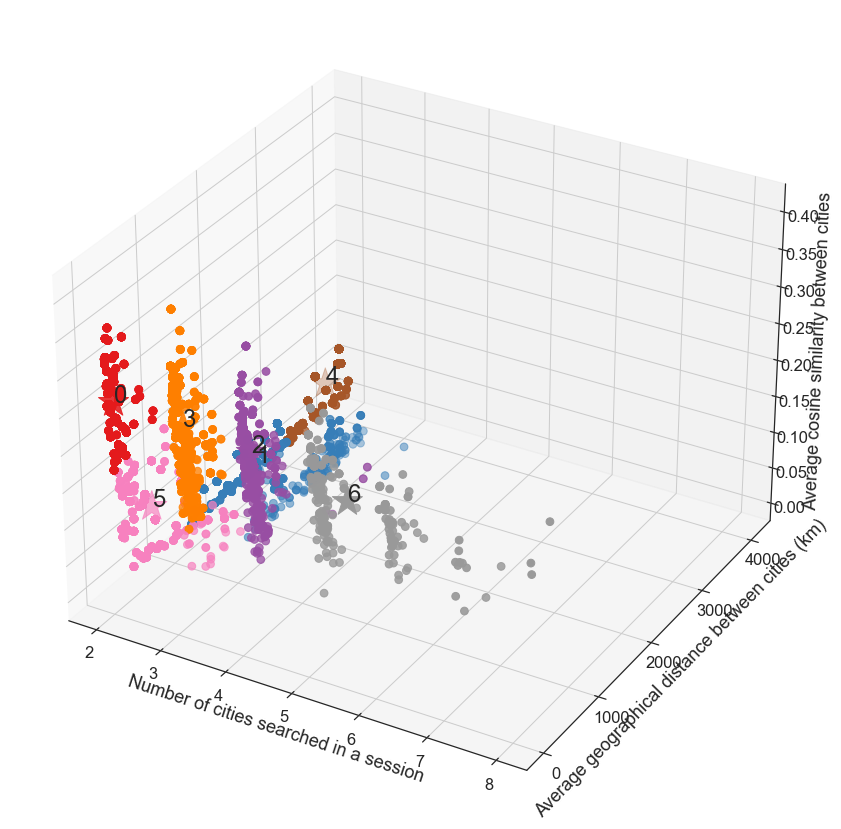

In [451]:
# Plot the clusters with the three variables in a 3D scatter plot with the cluster labels
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_cluster['city_count'], data_cluster['average_geo_distance'], data_cluster['average_cosine_similarity'], c=clusters.labels_, cmap='Set1', s=60)
ax.set_xlabel('Number of cities searched in a session')
ax.set_ylabel('Average geographical distance between cities (km)')
ax.set_zlabel('Average cosine similarity between cities')
# Show the cluster centroids and label them
ax.scatter(reverse_transformed_centroids['city_count'], reverse_transformed_centroids['average_geo_distance'], reverse_transformed_centroids['average_cosine_similarity'], c=reverse_transformed_centroids['label'], cmap='Set1', s=1000, marker='*')
for i in range(reverse_transformed_centroids.shape[0]):
    ax.text(reverse_transformed_centroids.iloc[i, 0], reverse_transformed_centroids.iloc[i, 1], reverse_transformed_centroids.iloc[i, 2], reverse_transformed_centroids.iloc[i, 3], fontsize=24)

plt.show()

## Conclusion


We have three features to evaluate if a session is from a user that is actually planning a recent trip:
* Number of cities searched in a session
* Average geographical distance between cities searched in a session
* Average cosine similarity between cities searched in a session

The clustering analysis grouped the sessions into seven clusters based on the three features above:
* Cluster 0 consists of sessions with fewer cities searched (two cities). The cities are geographically closest (around 115 km apart) and are most commonly searched together by users in a session (cosine similarity around 0.2563). This cluster represents sessions from people who are **planning a trip**.
* Clusters 2 and 3 have a similar cosine similarity to cluster 0, but feature a slightly larger geographical distance and more cities searched on average in a session. These might represent a large metropolitan area with several cities, such as the Los Angeles metropolitan area, where people could be searching for hotels in different satellite cities. We also consider these clusters as being from people who are **planning a trip**.
* Cluster 6 has a larger geographical distance and a slightly lower cosine similarity compared to the clusters above. This might include people planning trips in a geographical region larger than metropolitan areas, such as the Upper Midwest (Minneapolis, MN - Madison, WI) or Pacific Northwest (Seattle, WA - Portland, OR). We still consider this cluster as representing people who are planning a recent trip, but with a **less clear intent** of where they will go.
* Cluster 5 has a larger geographical distance (>600 km) and lower cosine similarity. This might include people who have an idea about a **trip in the future** but have not yet decided on a specific region to visit.
* Clusters 1 and 4 include sessions with around two cities searched, but with extreme geographical distance (>2000 km) and very low cosine similarity. This suggests that fewer users search for these destinations together. We consider these clusters as representing people who **do not have high intent** to book hotels..

In [468]:
reverse_transformed_centroids

,city_count,average_geo_distance,average_cosine_similarity,label,size
0,2.000000,115.826554,0.256345,0,2488
1,2.167021,2236.965652,0.036974,1,1413
2,4.000000,205.402417,0.236581,2,559
3,3.000000,174.630171,0.246716,3,1367
4,2.000000,3678.059548,0.050087,4,1309
5,2.033826,619.711696,0.082202,5,2099
6,5.367521,262.170997,0.204372,6,234


## Next steps

A common next step at this point could be developing a retargeting strategy. Based on the model's clustering results, we will devise a strategy to retarget users who have a high likelihood of booking but haven't done so yet. This could involve:

* Personalized email reminders: Sending emails to remind users with high booking intent to complete their transactions.
* Personalized email marketing: Distributing custom offers and recommendations based on user preferences.
* Display advertising: Presenting personalized ads to these users when they visit other websites.
* Website personalization: Tailoring the website experience for these users when they return.

We will work on developing a personalized email reminder for the next project.
